# Create RGB images

This notebook is an introduction to FITS image manipulation to create RGB images out of JWST images. Be careful when working with big images as they could make the kernel crash.

In [18]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from astropy.io import fits
from astropy.visualization import ImageNormalize, MinMaxInterval, ZScaleInterval, LogStretch, make_lupton_rgb
from astropy.visualization.wcsaxes import add_scalebar
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
import astropy.units as u

First, we select the images and bands we want to use for each color.

In [19]:
field = "GDS"
filters = {'b':'f150w', 'g':'f277w', 'r':'f444w'}

b_hdu = fits.open(glob.glob(f"/home/ec2-user/DAWN/DJA-SEpp/image/{field}/*{filters['b']}*sci_cutout.fits")[0], memmap=True)[0]
g_hdu = fits.open(glob.glob(f"/home/ec2-user/DAWN/DJA-SEpp/image/{field}/*{filters['g']}*sci_cutout.fits")[0], memmap=True)[0]
r_hdu = fits.open(glob.glob(f"/home/ec2-user/DAWN/DJA-SEpp/image/{field}/*{filters['r']}*sci_cutout.fits")[0], memmap=True)[0]

Then, since the long-wavelength channel of JWST/NIRCam has pixel twice as big as the ones from the short-wavelength channel, we down-sample the images from the short-wavelength channel (if any are used).

In [20]:
min_x = min(b_hdu.header["NAXIS1"], g_hdu.header["NAXIS1"], r_hdu.header["NAXIS1"])
if b_hdu.header["NAXIS1"] > min_x:
    print("B channel pixel scale is too high ! Down-sampling")
    b_image = b_hdu.data[::2,::2]
else: 
    b_image = b_hdu.data
    wcs = WCS(b_hdu.header)
if g_hdu.header["NAXIS1"] > min_x:
    print("G channel pixel scale is too high ! Down-sampling")
    g_image = g_hdu.data[::2,::2]
else: 
    g_image = g_hdu.data
    wcs = WCS(g_hdu.header)
if r_hdu.header["NAXIS1"] > min_x:
    print("R channel pixel scale is too high ! Down-sampling")
    r_image = r_hdu.data[::2,::2]
else: 
    r_image = r_hdu.data
    wcs = WCS(r_hdu.header)

B channel pixel scale is too high ! Down-sampling


Here we stack the images to create a full RGB image. We normalize each channel by its maximum value and multiply if by a constant (that can be tweaked) as a crude white-balance.

In [21]:
rgb = np.stack([0.6*r_image/np.max(r_image), 0.3*g_image/np.max(g_image), 1.0*b_image/np.max(b_image)], axis=-1)

Finally, we can display the full RGB image, with a legend showing which bands were used, and a scale bar to show the scale of the image.

In [22]:
def add_good_scalebar(ax, wcs, color='white', fraction=0.25, corner='bottom right', fontsize='x-large', pad=0.1):
    """
    Utility function for astropy.visualization.wcsaxes.add_scalebar
    to automaticaly resize the scalebar to the size of the image.

    ax : matplotlib.pyplot.Axes where to draw the scale bar
    wcs : WCS of the image
    color : color of the scale bar
    fraction : fraction of the image to aim for the scale bar (will always be smaller)
    corner : where to place the scale bar
    fontsize : fontsize to use for the scale over the scale bar
    pad : padding around the scale bar
    """
    width = abs(proj_plane_pixel_scales(wcs)[0]*wcs.pixel_shape[0])*u.degree
    good_values = [0.5*u.arcsec, 1*u.arcsec, 2*u.arcsec, 3*u.arcsec, 5*u.arcsec, 10*u.arcsec, 20*u.arcsec,
                0.5*u.arcmin, 1*u.arcmin, 2*u.arcmin, 3*u.arcmin, 5*u.arcmin, 10*u.arcmin, 20*u.arcmin,
                0.5*u.degree, 1*u.degree, 2*u.degree, 5*u.degree, 10*u.degree]
    dist = np.array([(fraction*width-val).value for val in good_values])
    dist[dist<0] = np.inf
    size = good_values[np.argmin(dist)]
    add_scalebar(ax, size, label=f"{size:latex}", color=color, fontproperties=FontProperties(size=fontsize), label_top=True, pad=pad, corner=corner)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


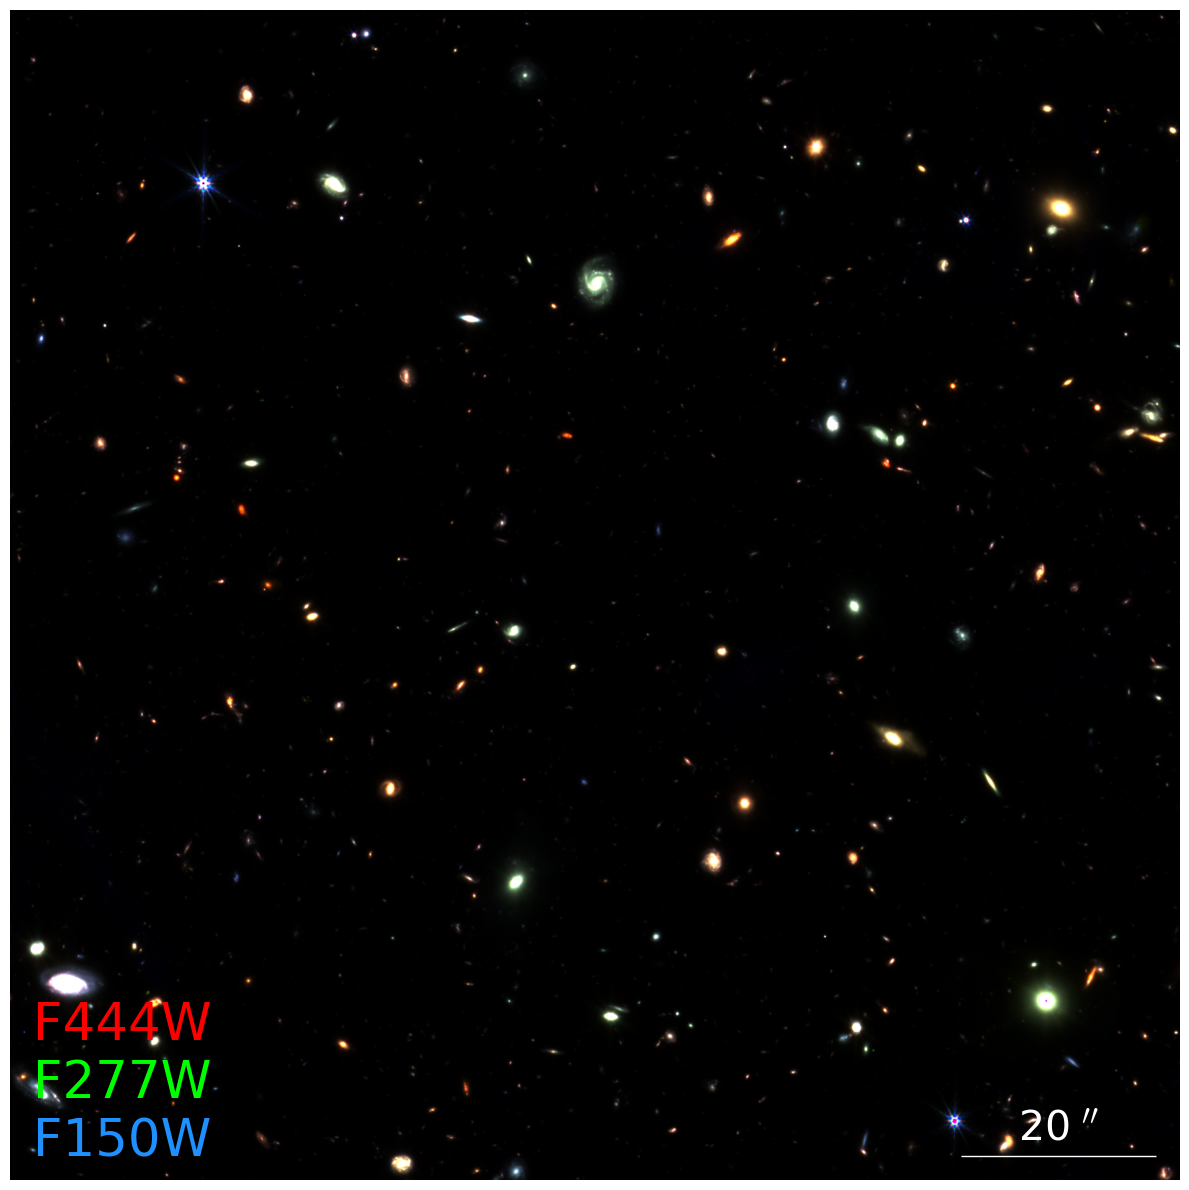

In [25]:
# %matplotlib ipympl
fig, ax = plt.subplots(figsize=(12,12), subplot_kw={'projection':wcs})
# norm = ImageNormalize(rgb, interval=ZScaleInterval())
norm = ImageNormalize(rgb, interval=MinMaxInterval(), stretch=LogStretch())
ax.imshow(255*rgb, origin='lower', norm=norm)
y1, y2 = ax.get_window_extent().get_points()[:,1]
y = rgb.shape[0]
fontsize = 120 * (y2-y1)/y
ax.text(0.02, 0.02, filters['b'].upper(), transform=ax.transAxes, color='dodgerblue', fontsize=fontsize)
ax.text(0.02, 0.07, filters['g'].upper(), transform=ax.transAxes, color='lime', fontsize=fontsize)
ax.text(0.02, 0.12, filters['r'].upper(), transform=ax.transAxes, color='red', fontsize=fontsize)
ax.set_axis_off()
add_good_scalebar(ax, wcs, fontsize=0.8*fontsize, pad=0.005*fontsize)
fig.tight_layout()
fig.savefig(f"/home/ec2-user/DAWN/DJA-SEpp/rgb_images/{field}_RGB.png", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()